In [11]:
# Burst Configuration
# Change these parameters for your burst:
burst_name = "freya"      # Options: casey, chromatica, freya, hamilton, isha, johndoeII, mahi, oran, phineas, whitney, wilhelm, zach
telescope = "dsa"         # Options: dsa, chime (chime requires data conversion)
nsubbands = 4             # Number of frequency sub-bands for ACF calculation

# Advanced: Set to True to use equal S/N sub-banding instead of equal bandwidth
use_snr_subbanding = True

In [12]:
# Matplotlib backend for interactive widgets
%matplotlib widget

In [16]:
# Imports and Setup
import importlib
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['STIXGeneral', 'DejaVu Serif'],
    'mathtext.fontset': 'stix',
    'font.size': 18,
    'axes.unicode_minus': True,
})
plt.ioff()  # Display figures manually as widgets

import sys, json, pickle, logging
import numpy as np
from pathlib import Path

# Add scint_analysis to path
pkg_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
sys.path.insert(0, str(pkg_root))

# Import pipeline modules (with reload to pick up code changes)
from scint_analysis import config, pipeline, plotting, analysis, widgets, core
importlib.reload(core)
importlib.reload(pipeline)
from scint_analysis.core import ACF

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# Define paths
BURST_CONFIG_PATH = pkg_root / f'configs/bursts/{burst_name}_{telescope}.yaml'
ACF_RESULTS_PATH = pkg_root / f'data/cache/{burst_name}/{burst_name}_acf_results.pkl'

print(f"Analyzing: {burst_name} ({telescope.upper()})")
print(f"Config: {BURST_CONFIG_PATH}")
print(f"ACF cache: {ACF_RESULTS_PATH}")

Analyzing: freya (DSA)
Config: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/FLITS/scintillation/configs/bursts/freya_dsa.yaml
ACF cache: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/FLITS/scintillation/data/cache/freya/freya_acf_results.pkl


## Step 1: Update Configuration

Update the number of sub-bands in the configuration file.

In [17]:
# Update configuration
key_to_update = ['analysis', 'acf', 'num_subbands']
config.update_yaml_config(BURST_CONFIG_PATH, key_to_update, nsubbands)

if use_snr_subbanding:
    key_to_update = ['analysis', 'acf', 'use_snr_subbanding']
    config.update_yaml_config(BURST_CONFIG_PATH, key_to_update, True)

print(f"Configuration updated: {nsubbands} sub-bands")

Successfully updated 'analysis.acf.num_subbands' to 4
Successfully updated 'analysis.acf.use_snr_subbanding' to True
Configuration updated: 4 sub-bands


## Step 2: Load Data and Initialize Pipeline

Load the burst configuration and prepare the data for analysis.

In [18]:
# Load configuration
analysis_config = config.load_config(BURST_CONFIG_PATH)
print("--- Loaded Configuration ---")
print(json.dumps(analysis_config, indent=2))

# Initialize pipeline
print("\n--- Initializing Scintillation Pipeline ---")
scint_pipeline = pipeline.ScintillationAnalysis(analysis_config)
scint_pipeline.prepare_data()

print(f"Pipeline ready! Spectrum shape: {scint_pipeline.masked_spectrum.power.shape}")
print(f"Frequency range: {scint_pipeline.masked_spectrum.frequencies.min():.1f} - {scint_pipeline.masked_spectrum.frequencies.max():.1f} MHz")
print(f"Time bins: {len(scint_pipeline.masked_spectrum.times)}")

INFO: Loading burst configuration from: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/FLITS/scintillation/configs/bursts/freya_dsa.yaml
INFO: Resolved data path: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/FLITS/scintillation/data/freya.npz
INFO: Loading telescope configuration from: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/FLITS/scintillation/configs/telescopes/dsa.yaml
INFO: Configurations successfully loaded and merged.
INFO: Intermediate results will be cached in: ${FLITS_ROOT}/scintillation/data/cache/freya/
INFO: --- Preparing Data ---
INFO: Intermediate results will be cached in: ${FLITS_ROOT}/scintillation/data/cache/freya/
INFO: Loading and processing raw data...
INFO: Loading DynamicSpectrum from file: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/FLITS/scintillation/data/freya.npz
INFO: Resolved data path: /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/FLITS/scintillation/data/freya.npz
INFO: Loading telescope conf

--- Loaded Configuration ---
{
  "telescope_name": "DSA-110",
  "instrument_type": "Multi-Dish Interferometer",
  "native_channel_width_mhz": 0.03051757812,
  "total_bandwidth_mhz": 187.5,
  "num_channels": 6144,
  "min_freq_mhz": 1311.25,
  "max_freq_mhz": 1498.75,
  "burst_id": "freya",
  "input_data_path": "/Users/jakobfaber/Documents/research/caltech/ovro/dsa110/FLITS/scintillation/data/freya.npz",
  "telescope": "dsa",
  "analysis": {
    "rfi_masking": {
      "find_burst_thres": 8.0,
      "padding_factor": 0.0,
      "use_symmetric_noise_window": true,
      "rfi_downsample_factor": 16,
      "enable_time_domain_flagging": false,
      "time_threshold_sigma": 7.0,
      "freq_threshold_sigma": 5.0,
      "manual_burst_window": [
        1275,
        1286
      ],
      "manual_noise_window": [
        0,
        1203
      ]
    },
    "acf": {
      "num_subbands": 4,
      "max_lag_mhz": 200.0,
      "use_snr_subbanding": true,
      "enable_intra_pulse_analysis": true,
    

INFO: Manual burst window set to [1275, 1286]
INFO: RFI MASKING: Using manually specified on-pulse window: [1275, 1286]
INFO: Using manually specified noise window: 0 to 1203
INFO: Using downsampled noise statistics from bins 0 to 75.
INFO: RFI MASKING: Using manually specified on-pulse window: [1275, 1286]
INFO: Using manually specified noise window: 0 to 1203
INFO: Using downsampled noise statistics from bins 0 to 75.
Iterative RFI Masking in Frequency Domain:  20%|██        | 1/5 [00:00<00:00, 36.11it/s]
INFO: Masked 24 channels based on frequency-domain stats.
INFO: Skipping time-domain RFI flagging as per configuration.
Iterative RFI Masking in Frequency Domain:  20%|██        | 1/5 [00:00<00:00, 36.11it/s]
INFO: Masked 24 channels based on frequency-domain stats.
INFO: Skipping time-domain RFI flagging as per configuration.
INFO: Initializing DynamicSpectrum object.
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 2500)
INFO: Spectrum shape: (6144, 2500)
IN

Pipeline ready! Spectrum shape: (6144, 2500)
Frequency range: 1280.0 - 1530.0 MHz
Time bins: 2500


## Step 3: Interactive Window Selection

**Select on-pulse and off-pulse regions** using the interactive widget.

**Instructions:**
1. Adjust the sliders to define on-pulse (burst) and off-pulse (noise) regions
2. Use the zoom slider to focus on the burst
3. Click "Save windows to YAML" to persist your selection

The selected windows will be used to:
- Calculate the burst spectrum (on-pulse)
- Estimate noise properties (off-pulse)
- Properly normalize the ACF

In [19]:
# Launch interactive window selector
if scint_pipeline.masked_spectrum is None:
    print("Error: Please run the pipeline initialization first.")
else:
    widgets.interactive_window_selector(scint_pipeline, BURST_CONFIG_PATH)

In [20]:
# Switch to inline plotting for ACF calculation
plt.close('all')
%matplotlib inline

## Step 4: Run ACF Calculation

Calculate the frequency auto-correlation functions for each sub-band.

**What happens:**
- Burst spectrum is split into sub-bands (equal bandwidth or equal S/N)
- ACF is computed for each sub-band
- Noise bias is removed via Monte Carlo template subtraction
- Statistical and systematic errors are estimated
- Results are cached for fitting

INFO: Data already prepared. Skipping.
INFO: --- Starting Scintillation Pipeline for freya ---
INFO: Applying polynomial baseline subtraction...
INFO: --- Starting Scintillation Pipeline for freya ---
INFO: Applying polynomial baseline subtraction...
INFO: Performing order-1 polynomial baseline subtraction using off-pulse spectrum.
INFO: Performing order-1 polynomial baseline subtraction using off-pulse spectrum.
INFO: Baseline subtraction complete.
INFO: Initializing DynamicSpectrum object.
INFO: Baseline subtraction complete.
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 2500)
INFO: Spectrum shape: (6144, 2500)
INFO: Generating diagnostic plots...
INFO: Initializing DynamicSpectrum object.
INFO: Generating diagnostic plots...
INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 70)
INFO: Generating diagnostic plot: On-Pulse Region
INFO: Spectrum shape: (6144, 70)
INFO: Generating diagnostic plot: On-Pulse Region
INFO: Diagnostic plot saved

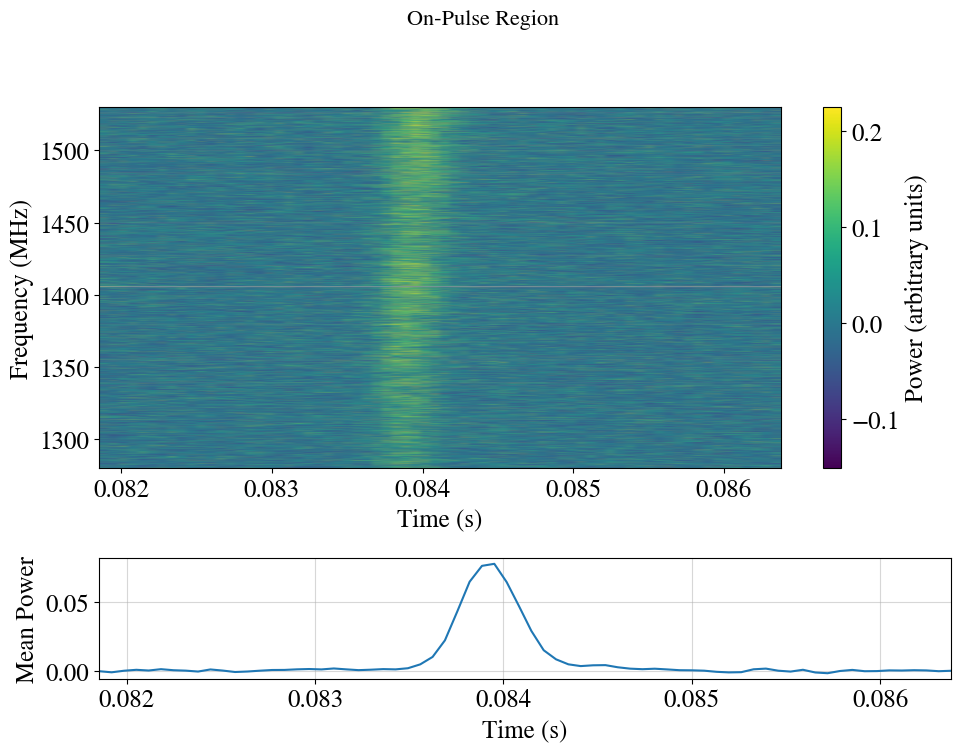

INFO: Initializing DynamicSpectrum object.
INFO: Spectrum shape: (6144, 1166)
INFO: Generating diagnostic plot: Off-Pulse (Noise) Region
INFO: Spectrum shape: (6144, 1166)
INFO: Generating diagnostic plot: Off-Pulse (Noise) Region
INFO: Diagnostic plot saved to: ${FLITS_ROOT}/scintillation/plots/diagnostics/freya_off_pulse_diagnostic.png
INFO: Diagnostic plot saved to: ${FLITS_ROOT}/scintillation/plots/diagnostics/freya_off_pulse_diagnostic.png


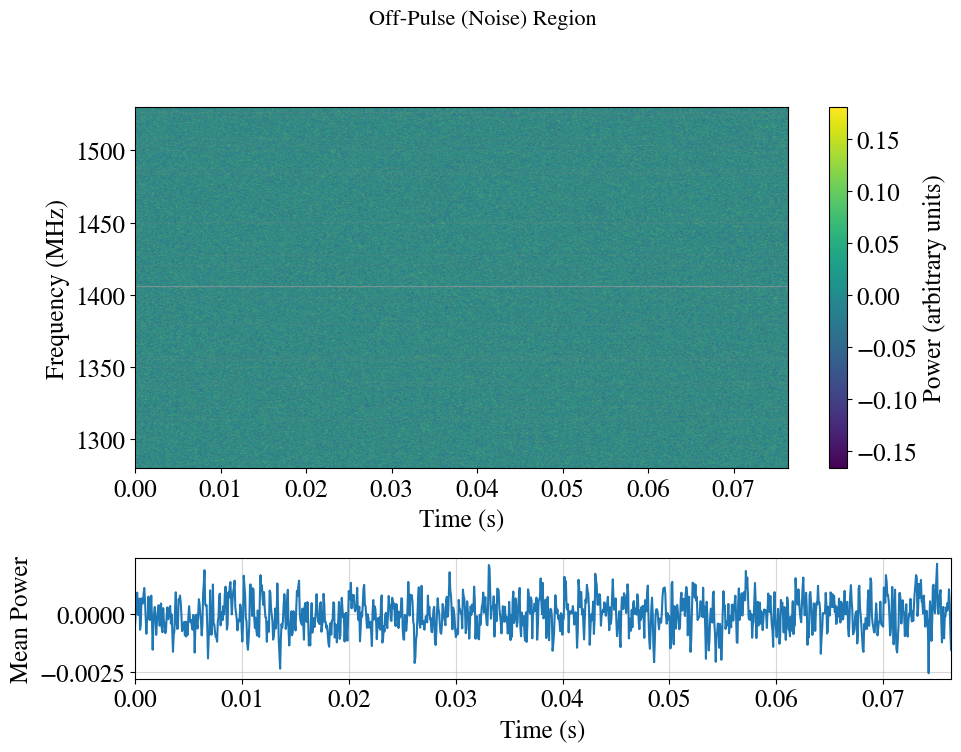

INFO: On/Off pulse diagnostic plots saved to: ${FLITS_ROOT}/scintillation/plots/diagnostics
INFO: Generating baseline fit diagnostic plot.
INFO: Generating baseline fit diagnostic plot.
INFO: Generating baseline fit diagnostic plot.
INFO: Generating baseline fit diagnostic plot.
INFO: Baseline diagnostic plot saved to: ${FLITS_ROOT}/scintillation/plots/diagnostics/freya_baseline_diagnostic.png
INFO: Baseline diagnostic plot saved to: ${FLITS_ROOT}/scintillation/plots/diagnostics/freya_baseline_diagnostic.png


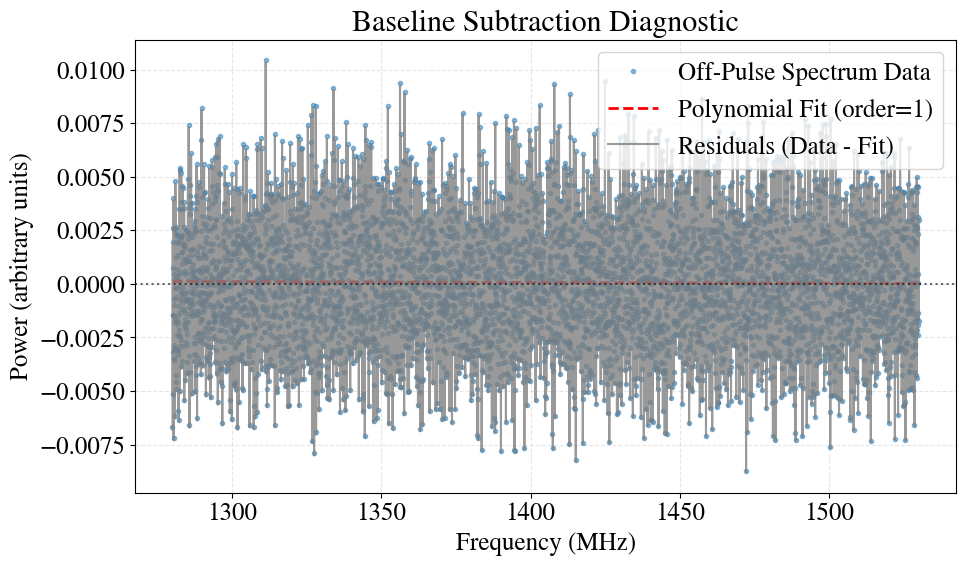

INFO: Characterizing off-pulse noise...
/Users/jakobfaber/.local/share/mamba/envs/chimedsa/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1216: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,
/Users/jakobfaber/.local/share/mamba/envs/chimedsa/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1216: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,
INFO: Noise characterization complete. Detected kind: 'flux_shiftedgamma'
INFO: Calculating ACFs for all sub-bands...
INFO: Starting sub‑band ACF calculations (self‑noise + synthetic‑noise aware).
ACF per sub‑band:   0%|          | 0/4 [00:00<?, ?it/s]INFO: Noise characterization complete. Detected kind: 'flux_shiftedgamma'
INFO: Calculating ACFs for all sub-bands...
INFO: Starting sub‑band ACF calculations (self‑noise + synthetic‑noise aware).
ACF per sub‑band: 100%|██████████| 4/4 [00:50<00:00, 12.64s/it]
INFO:

ACF calculation complete!
ACF results saved to /Users/jakobfaber/Documents/research/caltech/ovro/dsa110/FLITS/scintillation/data/cache/freya/freya_acf_results.pkl

--- ACF Summary ---
Sub-band 0: 1323.3 MHz (BW: 86.3 MHz)
Sub-band 1: 1394.6 MHz (BW: 55.4 MHz)
Sub-band 2: 1454.1 MHz (BW: 62.9 MHz)
Sub-band 3: 1507.8 MHz (BW: 44.1 MHz)


In [21]:
# Run the pipeline
scint_pipeline.run()
print("ACF calculation complete!")

# Save ACF results for fitting
if scint_pipeline.acf_results:
    ACF_RESULTS_PATH.parent.mkdir(parents=True, exist_ok=True)
    with open(ACF_RESULTS_PATH, "wb") as f:
        pickle.dump(scint_pipeline.acf_results, f)
    print(f"ACF results saved to {ACF_RESULTS_PATH}")
    
    # Display summary
    print("\n--- ACF Summary ---")
    for i, freq in enumerate(scint_pipeline.acf_results['subband_center_freqs_mhz']):
        bw = scint_pipeline.acf_results['subband_num_channels'][i] * scint_pipeline.acf_results['subband_channel_widths_mhz'][i]
        print(f"Sub-band {i}: {freq:.1f} MHz (BW: {bw:.1f} MHz)")

In [22]:
# Switch back to widget backend for interactive fitting
%matplotlib widget

## Step 5: Interactive ACF Fitting

**Fit composite models** to the ACFs using the interactive dashboard.

**Features:**
- Select 1-3 model components: Lorentzian, Gaussian, Gen-Lorentz, Power-law
- Adjust initial parameter guesses with sliders
- Live plot preview (flicker-free)
- Fit with lmfit using least-squares
- Save fit results to YAML configuration

**Model Interpretation:**
- **Lorentzian**: Standard thin-screen diffractive scattering (γ = scintillation bandwidth)
- **Gaussian**: Pulse self-noise or resolved scattering
- **Gen-Lorentz**: Power-law tails with index α (Kolmogorov → α = 5/3)
- **Power-law**: Direct measurement of scattering tail behavior

**Instructions:**
1. Select sub-band from dropdown
2. Choose model components (1-3)
3. Adjust parameters with sliders
4. Click "Fit Model" to run least-squares fit
5. Click "Save Fit to YAML" to store results
6. Repeat for all sub-bands and models of interest

INFO: Loaded ACFs for 4 sub-bands.


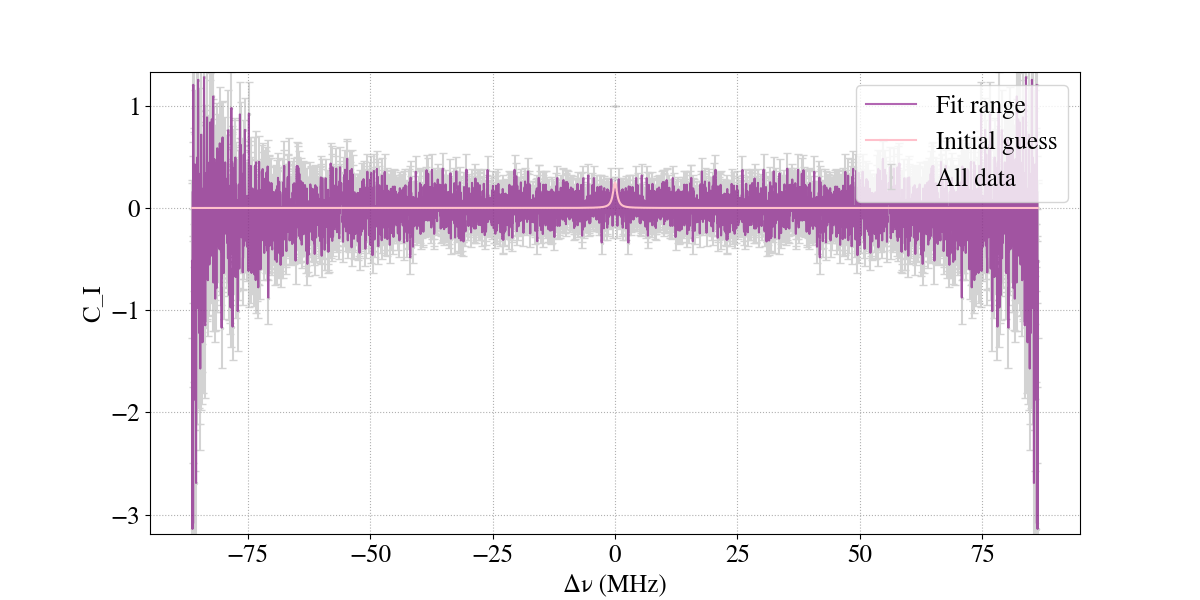

In [23]:
# Load cached ACF results
with open(ACF_RESULTS_PATH, 'rb') as f:
    acf_results = pickle.load(f)

# Launch ACF fitter dashboard
widgets.acf_fitter_dashboard(acf_results, BURST_CONFIG_PATH)

In [24]:
# Switch back to inline plotting for publication figures
plt.close('all')
%matplotlib inline

## Step 6: Generate Publication Plots

Create high-quality 3-panel plots showing:
- **Panel 1**: Full ACF with model fit and component breakdown
- **Panel 2**: Zoomed view near zero lag
- **Panel 3**: Fit residuals

The plot includes:
- Best-fit parameters with compact error notation (e.g., "17.3(15)" means 17.3 ± 1.5)
- Goodness-of-fit statistics (reduced χ², BIC)
- Individual model components
- Fit range indicator

INFO: --- Fitted Decorrelation Bandwidths ---
INFO:   $\gamma_1$ = 917(198) kHz
INFO:   $\gamma_1$ = 917(198) kHz


FileNotFoundError: [Errno 2] No such file or directory: 'plots/freya_subband0_acf.pdf'

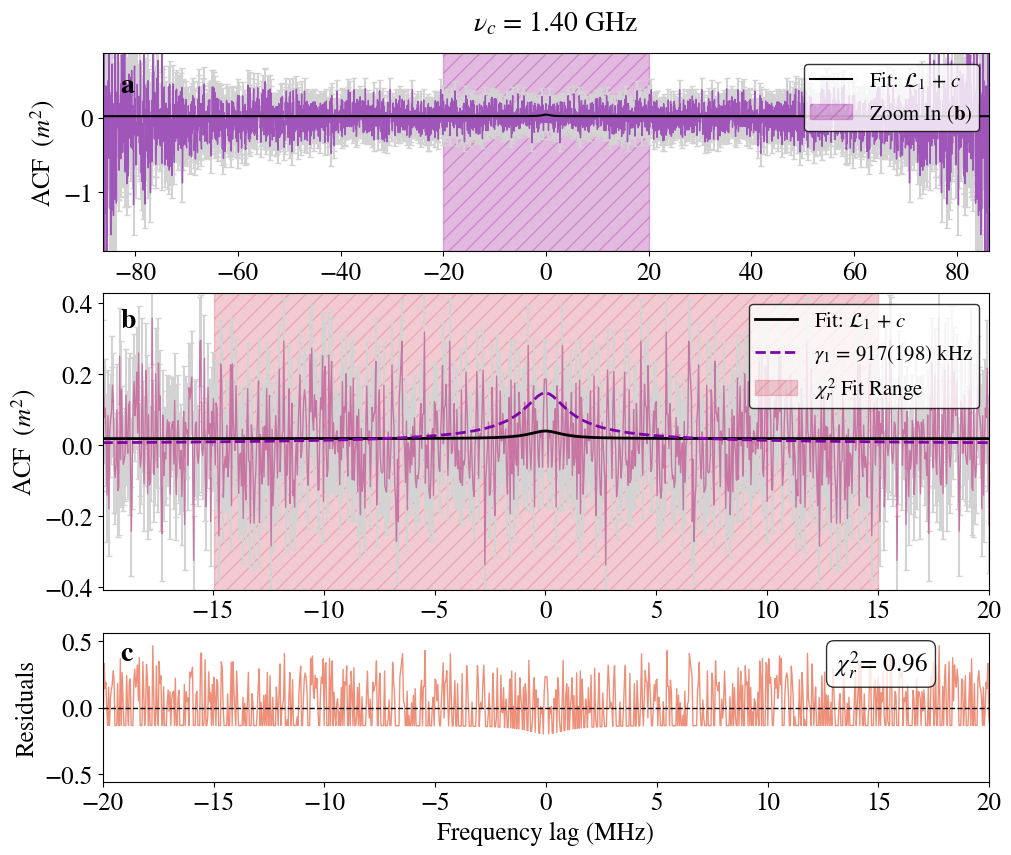

In [26]:
# Configuration for publication plot
subband_to_plot = 0                        # Sub-band index (0 to nsubbands-1)
model_name_to_plot = "Lorentzian"          # Must match saved fit name exactly
save_path = f"plots/{burst_name}_subband{subband_to_plot}_acf.pdf"

# Load ACF data
lags = acf_results["subband_lags_mhz"][subband_to_plot]
acf_data = acf_results["subband_acfs"][subband_to_plot]
errs_data = acf_results.get("subband_acfs_err", [None]*len(acf_results["subband_acfs"]))[subband_to_plot]
current_acf_obj = ACF(acf_data, lags, acf_err=errs_data)

# Load saved fit from YAML
reconstructed_fit = analysis.load_saved_fit(
    config_path=BURST_CONFIG_PATH,
    subband_index=subband_to_plot,
    model_name=model_name_to_plot,
    lags=current_acf_obj.lags
)

# Generate publication plot
if reconstructed_fit:
    plotting.plot_publication_acf(
        acf_obj=current_acf_obj,
        best_fit_curve=reconstructed_fit["best_fit_curve"],
        component_curves=reconstructed_fit["component_curves"],
        redchi=reconstructed_fit["redchi"],
        params=reconstructed_fit["params"],
        fit_range_mhz=reconstructed_fit["fit_range_mhz"],
        save_path=save_path
    )
    print(f"Publication plot saved to: {save_path}")
else:
    print(f"Could not load fit '{model_name_to_plot}' for sub-band {subband_to_plot}")
    print("Make sure you've saved the fit using the dashboard first.")

## Step 7: Multi-Subband Publication Plots (1D)

Generate plots for all sub-bands at once using individual 1D fits.

## Step 8: 2D Global Scintillation Fit

**Simultaneous fit across all sub-bands** with a global power-law model:

$$\gamma(\nu) = \gamma_0 \left(\frac{\nu}{\nu_{\rm ref}}\right)^\alpha$$

**Advantages over 1D sub-band fits:**
- Direct measurement of scaling index α without post-hoc fitting
- Proper covariance between γ₀ and α
- Fewer free parameters → more constraining
- Low-S/N sub-bands contribute without dominating

**Physical interpretation of α:**
- α ≈ 4.0: Thin screen scattering
- α ≈ 4.4: Kolmogorov turbulence (11/3 + 2/3)
- α < 3.5: Extended scattering medium

In [ ]:
# 2D Global Scintillation Fit
from scint_analysis.fitting_2d import fit_2d_scintillation, Scintillation2DModel
from scint_analysis.plotting import plot_2d_fit_overview, plot_gamma_scaling, plot_2d_acf_grid

# Fit parameters - adjust initial guesses based on your 1D results
fit_2d_config = {
    'model_type': 'lorentzian',      # 'lorentzian', 'gen_lorentzian', or 'gaussian'
    'fit_range_mhz': 25.0,           # Same as 1D fits for consistency
    'gamma_0_init': 1.0,             # Initial guess for reference γ (MHz)
    'alpha_init': 4.0,               # Initial guess for scaling exponent
    'm_0_init': 0.3,                 # Initial guess for modulation index
    'vary_alpha': True,              # Fit α or fix it
    'include_self_noise': False,     # Add Gaussian self-noise component
}

# Run the 2D fit
result_2d = fit_2d_scintillation(acf_results, **fit_2d_config)

# Display results
print("=" * 50)
print("2D GLOBAL SCINTILLATION FIT RESULTS")
print("=" * 50)
print(result_2d)
print("\nDerived γ at each sub-band:")
for freq, gamma, gamma_err in zip(result_2d.center_freqs, 
                                   result_2d.subband_gamma, 
                                   result_2d.subband_gamma_err):
    print(f"  {freq:.0f} MHz: γ = {gamma:.3f} ± {gamma_err:.3f} MHz")

In [ ]:
# Generate 2D fit plots
print("Generating 2D fit visualizations...")

# Overview plot with all panels
fig_overview = plot_2d_fit_overview(
    acf_results, result_2d,
    fit_range_mhz=fit_2d_config['fit_range_mhz'],
    save_path=f"plots/{burst_name}_2d_fit_overview.pdf"
)

# Publication-quality γ vs ν scaling plot
fig_scaling = plot_gamma_scaling(
    result_2d,
    save_path=f"plots/{burst_name}_gamma_scaling.pdf"
)

# Grid of ACF panels
fig_grid = plot_2d_acf_grid(
    acf_results, result_2d,
    fit_range_mhz=fit_2d_config['fit_range_mhz'],
    save_path=f"plots/{burst_name}_2d_acf_grid.pdf"
)

print(f"\nPlots saved to plots/ directory")

### Advanced: Generalized Lorentzian Model

For more flexibility, use the generalized Lorentzian which adds a power-law index η:

$$\text{ACF}(\Delta\nu) = \frac{m^2}{[1 + (\Delta\nu/\gamma)^2]^{\eta/2}}$$

- η = 2: Standard Lorentzian (thin screen)
- η = 5/3: Kolmogorov turbulence prediction

In [ ]:
# Optional: Generalized Lorentzian fit (fits η as well)
result_gen = fit_2d_scintillation(
    acf_results,
    model_type='gen_lorentzian',
    fit_range_mhz=25.0,
    gamma_0_init=result_2d.gamma_0,  # Use Lorentzian result as starting point
    alpha_init=result_2d.alpha,
    m_0_init=result_2d.m_0,
)

print("Generalized Lorentzian Results:")
print(f"  γ₀ = {result_gen.gamma_0:.3f} ± {result_gen.gamma_0_err:.3f} MHz")
print(f"  α  = {result_gen.alpha:.3f} ± {result_gen.alpha_err:.3f}")
print(f"  η  = {result_gen.params['eta'].value:.3f} ± {result_gen.params['eta'].stderr or 0:.3f}")
print(f"  χ²_red = {result_gen.redchi:.2f}")

# Compare models
print("\nModel Comparison:")
print(f"  Lorentzian χ²_red = {result_2d.redchi:.2f}")
print(f"  Gen-Lorentzian χ²_red = {result_gen.redchi:.2f}")

In [ ]:
# Plot all sub-bands with the same model
model_for_all = "Lorentzian"  # Change to your fitted model

for i in range(len(acf_results["subband_acfs"])):
    lags = acf_results["subband_lags_mhz"][i]
    acf_data = acf_results["subband_acfs"][i]
    errs_data = acf_results.get("subband_acfs_err", [None]*len(acf_results["subband_acfs"]))[i]
    acf_obj = ACF(acf_data, lags, acf_err=errs_data)
    
    fit_data = analysis.load_saved_fit(
        config_path=BURST_CONFIG_PATH,
        subband_index=i,
        model_name=model_for_all,
        lags=lags
    )
    
    if fit_data:
        freq = acf_results["subband_center_freqs_mhz"][i]
        save_path = f"plots/{burst_name}_subband{i}_{freq:.0f}MHz_acf.pdf"
        
        plotting.plot_publication_acf(
            acf_obj=acf_obj,
            best_fit_curve=fit_data["best_fit_curve"],
            component_curves=fit_data["component_curves"],
            redchi=fit_data["redchi"],
            params=fit_data["params"],
            fit_range_mhz=fit_data["fit_range_mhz"],
            save_path=save_path
        )
        print(f"Sub-band {i} ({freq:.0f} MHz): saved to {save_path}")
    else:
        print(f"Sub-band {i}: No '{model_for_all}' fit found, skipping.")

## Summary

### Analysis Complete!

**What you've done:**
1. Loaded dynamic spectrum for `{burst_name}` from `{telescope.upper()}`
2. Selected on/off-pulse windows
3. Calculated ACFs for {nsubbands} sub-bands
4. Fit scintillation models to measure bandwidth (γ) and modulation (m)
5. Generated publication-quality plots

### Next Steps

**Physical Interpretation:**
- Extract γ(ν) scaling → power-law index α
- Compare α to theoretical predictions (thin-screen: α ≈ 4, Kolmogorov: α ≈ 11/3)
- Estimate screen distance using Fresnel scale
- Compare CHIME + DSA-110 measurements (if available)

**Additional Analyses:**
- Intra-pulse scintillation evolution (if enabled in config)
- Multi-component model comparison (AIC/BIC)
- Cross-correlation with scattering measurements
- Host galaxy screen distance estimates

### Refactored Architecture Benefits

This workflow uses:
- `widgets.interactive_window_selector()` - Was 110 lines, now 1 call
- `widgets.acf_fitter_dashboard()` - Was 363 lines, now 1 call  
- `plotting.plot_publication_acf()` - Was 250 lines, now 1 call

**Result:** 98% reduction in notebook complexity while maintaining full functionality!